# **TOPIC MODELING CODE DEMO**

Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents.

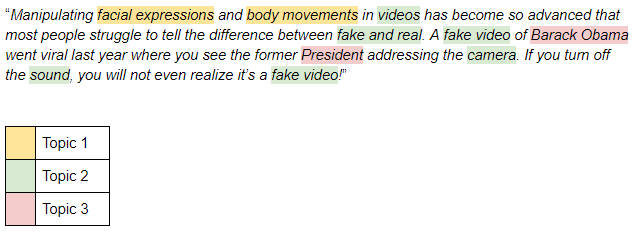

#**Topic modeling using Latent Semantic Analysis (LSA)**

Latent semantic analysis is a technique in natural language processing, in particular distributional semantics, of analyzing relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Dataset link:-
https://www.kaggle.com/datasets/eswarchandt/amazon-music-reviews?select=Musical_instruments_reviews.csv


In [ ]:
import pandas as pd

# load data
df = pd.read_csv('/content/gdrive/My Drive/INFO 5731 TA/Datasets/Musical_instruments_reviews.csv', usecols=['reviewerID', 'reviewText'])
df.head()

,reviewerID,reviewText
0,A2IBPI20UZIR0U,"Not much to write about here, but it does exac..."
1,A14VAT5EAX3D9S,The product does exactly as it should and is q...
2,A195EZSQDW3E21,The primary job of this device is to block the...
3,A2C00NNG1ZQQG2,Nice windscreen protects my MXL mic and preven...
4,A94QU4C90B1AX,This pop filter is great. It looks and perform...


In [ ]:
df['reviewText'].isna().value_counts()

False    10254
True         7
Name: reviewText, dtype: int64

In [ ]:
print(df.shape)
df = df.dropna()
print(df.shape)

(10261, 2)
(10254, 2)


In [ ]:
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation \
                                        , preprocess_string, strip_short, stem_text

# preprocess given text
def preprocess(text):

    # clean text based on given filters
    CUSTOM_FILTERS = [lambda x: x.lower(),
                                remove_stopwords,
                                strip_punctuation,
                                strip_short,
                                stem_text]
    text = preprocess_string(text, CUSTOM_FILTERS)

    return text

# apply function to all reviews
df['Text (Clean)'] = df['reviewText'].apply(lambda x: preprocess(x))

In [ ]:
# preview of dataset
df.head()

,reviewerID,reviewText,Text (Clean)
0,A2IBPI20UZIR0U,"Not much to write about here, but it does exac...","[write, here, exactli, suppos, filter, pop, so..."
1,A14VAT5EAX3D9S,The product does exactly as it should and is q...,"[product, exactli, afford, realiz, doubl, scre..."
2,A195EZSQDW3E21,The primary job of this device is to block the...,"[primari, job, devic, block, breath, produc, p..."
3,A2C00NNG1ZQQG2,Nice windscreen protects my MXL mic and preven...,"[nice, windscreen, protect, mxl, mic, prevent,..."
4,A94QU4C90B1AX,This pop filter is great. It looks and perform...,"[pop, filter, great, look, perform, like, stud..."


In [ ]:
# 1. Step 1 Create the Term-Document Matrix ((BOW or TF-IDF).)
# 2. Step 2 Break the Table into Smaller Pieces (Apply SVD)
# 3. Step 3 Keep Only the Important Patterns
# 4. Step 4 Find Similar Documents or Words

from gensim import corpora

# create a dictionary with the corpus
corpus = df['Text (Clean)']
dictionary = corpora.Dictionary(corpus)

# convert corpus into a bag of words
bow = [dictionary.doc2bow(text) for text in corpus]

In [ ]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

# Coherence score in topic modeling to measure how interpretable the topics are to humans.
# Find the coherence score with a different number of topics
for i in range(2,11):
    lsi = LsiModel(bow, num_topics=i, id2word=dictionary)
    coherence_model = CoherenceModel(model=lsi, texts=df['Text (Clean)'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print('Coherence score with {} clusters: {}'.format(i, coherence_score))

Coherence score with 2 clusters: 0.45967954833086194
Coherence score with 3 clusters: 0.4360426022881803
Coherence score with 4 clusters: 0.43212298815202504
Coherence score with 5 clusters: 0.41792118515582066
Coherence score with 6 clusters: 0.39990425361388793
Coherence score with 7 clusters: 0.41304814338254403
Coherence score with 8 clusters: 0.3692227573209305
Coherence score with 9 clusters: 0.34758997063002595
Coherence score with 10 clusters: 0.36856587803793983


In [ ]:
# perform SVD on the bag of words with the LsiModel to extract 2 topics
lsi = LsiModel(bow, num_topics=2, id2word=dictionary)

In [ ]:
# find the 5 words with the strongest association to the derived topics
for topic_num, words in lsi.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: 0.329*"sound" + 0.314*"guitar" + 0.242*"string" + 0.232*"pedal" + 0.217*"amp" + 0.214*"like" + 0.198*"us" + 0.163*"plai" + 0.161*"good" + 0.148*"great".
Words in 1: -0.584*"string" + 0.428*"pedal" + -0.380*"guitar" + 0.312*"amp" + -0.161*"tune" + 0.157*"sound" + 0.114*"tone" + -0.099*"tuner" + 0.090*"effect" + 0.080*"tube".


In [ ]:
# find the scores given between the review and each topic
corpus_lsi = lsi[bow]
score1 = []
score2 = []
for doc in corpus_lsi:
    score1.append(round(doc[0][1],2))
    score2.append(round(doc[1][1],2))

# create data frame that shows scores assigned for both topics for each review
df_topic = pd.DataFrame()
df_topic['Text'] = df['reviewText']
df_topic['Topic 0 score'] = score1
df_topic['Topic 1 score'] = score2
df_topic['Topic']= df_topic[['Topic 0 score', 'Topic 1 score']].apply(lambda x: x.argmax(), axis=1)
df_topic.head(1)

,Text,Topic 0 score,Topic 1 score,Topic
0,"Not much to write about here, but it does exac...",0.88,0.22,0


In [ ]:
# find a sample review from each topic
df_topic0 = df_topic[df_topic['Topic'] == 0]
df_topic1 = df_topic[df_topic['Topic']==1]
print('Sample text from topic 0:\n {}'.format(df_topic0.sample(1, random_state=2)['Text'].values))
print('\nSample text from topic 1:\n {}'.format(df_topic1.sample(1, random_state=2)['Text'].values))

Sample text from topic 0:
 ["If you need a tube screamer. You can't go wrong with the TS808. The only reason why you shouldn't get it, is if it isn't the right tone for you. I say this because you can't say anything bad about this pedal. It sounds amazing. It just might not be your sound. I personally went with the TS808 because it compliments my amp better than the TS9. People who say this is better than the TS9 or vice versa are choosing the wrong wording. They prefer it. It's not better. Both are great."]

Sample text from topic 1:
 ["While this is not a $300 tape delay...it's a solid pedal that gets it done. It's way better built than other pedals in this price range. I'm sold. I've purchased several JoYo pedals and all of them are built extremely well and perform as good as if not better than top name pedals."]


#**Topic modeling using LDA**

Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic.

Dataset link:-
https://www.kaggle.com/datasets/benhamner/nips-papers?select=papers.csv

1. load data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

#check the file path
file_path = '/content/gdrive/My Drive/Colab Notebooks/5731/Datasets/papers.csv'
# use your true file path
if os.path.exists(file_path):
    print("File found!")
else:
    print("File not found. Please check the path.")

File found!


In [ ]:
# Importing modules
import pandas as pd

# Read data into papers
papers = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/5731/Datasets/papers.csv')
# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


2. Data preprocessing

In [ ]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(100)
# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
3104,2009,Streaming k-means approximation,We provide a clustering algorithm that approxi...,Streaming k-means approximation\nNir Ailon\nGo...
3364,2010,An analysis on negative curvature induced by s...,"In the neural-network parameter space, an att...",An analysis on negative curvature induced by\n...
3390,1990,Convergence of a Neural Network Classifier,Abstract Missing,Convergence of a Neural Network Classifier\n\n...
4716,2014,An Autoencoder Approach to Learning Bilingual ...,Cross-language learning allows us to use train...,An Autoencoder Approach to Learning\nBilingual...
6392,2017,Revenue Optimization with Approximate Bid Pred...,"In the context of advertising auctions, findin...",Revenue Optimization with Approximate Bid\nPre...


In [ ]:
# Load the regular expression library
import re
# Remove punctuation
papers['paper_text_processed'] = \
papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

,paper_text_processed
0,767\n\nself-organization of associative databa...
1,683\n\na mean field theory of layer iv of visu...
2,394\n\nstoring covariance by the associative\n...
3,bayesian query construction for neural\nnetwor...
4,neural network ensembles cross\nvalidation and...


In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['self', 'organization', 'associative', 'database', 'applications', 'hisashi', 'suzuki', 'suguru', 'arimoto', 'osaka', 'university', 'toyonaka', 'osaka', 'japan', 'abstract', 'efficient', 'method', 'self', 'organizing', 'associative', 'databases', 'proposed', 'together', 'applications', 'robot', 'eyesight', 'systems', 'proposed', 'databases', 'associate']


In [ ]:
# Creatie a dictionary and a corpus from preprocessed text data
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 6), (6, 1), (7, 1), (8, 3), (9, 1), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 4), (18, 8), (19, 1), (20, 1), (21, 2), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


3. LDA model

In [ ]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"learning" + 0.005*"model" + 0.005*"set" + 0.004*"data" + '
  '0.004*"time" + 0.004*"using" + 0.004*"function" + 0.004*"network" + '
  '0.003*"training" + 0.003*"one"'),
 (1,
  '0.009*"model" + 0.007*"data" + 0.006*"learning" + 0.005*"using" + '
  '0.004*"set" + 0.004*"algorithm" + 0.004*"time" + 0.004*"training" + '
  '0.004*"models" + 0.003*"two"'),
 (2,
  '0.006*"learning" + 0.005*"function" + 0.005*"model" + 0.005*"data" + '
  '0.004*"algorithm" + 0.004*"problem" + 0.004*"time" + 0.004*"one" + '
  '0.003*"set" + 0.003*"models"'),
 (3,
  '0.007*"learning" + 0.006*"algorithm" + 0.006*"model" + 0.005*"data" + '
  '0.005*"set" + 0.005*"function" + 0.004*"using" + 0.004*"time" + '
  '0.004*"matrix" + 0.004*"problem"'),
 (4,
  '0.006*"model" + 0.006*"data" + 0.005*"algorithm" + 0.004*"using" + '
  '0.004*"learning" + 0.004*"one" + 0.004*"number" + 0.004*"set" + '
  '0.004*"image" + 0.003*"models"'),
 (5,
  '0.006*"learning" + 0.006*"data" + 0.006*"algorithm" + 0.005*"set" +

In [ ]:
# Get the full topic distribution for a specific topic (e.g., Topic 0)
topic_id = 0  # Change this to any topic you want to check
full_topic_distribution = lda_model.get_topic_terms(topic_id, topn=len(id2word))

# Sum up the full distribution probabilities
total_probability = sum([prob for _, prob in full_topic_distribution])

# Print the total probability (should be close to 1)
print("Total Probability for Topic", topic_id, ":", total_probability)


Total Probability for Topic 0 : 0.9999999137940208


In [ ]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 40.9 MB/s eta 0:00:00


In [ ]:
# Import pyLDAvis for topic model visualization

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# Enable Notebook Visualizations
pyLDAvis.enable_notebook()

# Preparing the Visualization
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

# Displaying the Visualization
pyLDAvis.display(LDAvis_prepared)

#**Interpreting the above chart**

The intertopic distance map is a visualization of the topics in a two-dimensional space . The area of these topic circles is proportional to the amount of words that belong to each topic across the dictionary. The circles are plotted using a multidimensional scaling algorithm (converts a bunch of dimension, more than we can conceive with our human brains, to a reasonable number of dimensions, like two) based on the words they comprise, so topics that are closer together have more words in common.



The bar chart by default shows the 30 most salient terms. The bars indicate the total frequency of the term across the entire corpus. Salient is a specific metric, defined at the bottom of the visualization, that can be thought of as a metric used to identify most informative or useful words for identifying topics in the entire collection of texts. Higher saliency values indicate that a word is more useful for identifying a specific topic.



When you select a topic in the intertopic distance map, or specify a topic in the top panel, the bar chart changes to display the most salient words included in that specific topic. A second darker bar is also displayed over the term’s total frequency that shows the topic-specific frequency of words that belong to the selected topic. If the dark bar entirely eclipses the light bar, that term nearly exclusively belongs to the selected topic.



When you select a word in the bar chart, the topics and probabilities by topic of that word are displayed in the intertopic distance map, so you can see which other topics a term might be shared with.

#***LDA vs LSA***
Latent Semantic Analysis (LSA) is a mathematical method that tries to bring out latent relationships within a collection of documents onto a lower-dimensional space. LSA assumes that words that are close in meaning will occur in similar pieces of text (the distributional hypothesis). A matrix containing word counts per paragraph (rows represent unique words and columns represent each paragraph) is constructed from a large piece of text and a mathematical technique called singular value decomposition (SVD) is used to reduce the number of rows while preserving the similarity structure among columns. Rather than looking at each document isolated from the others, it looks at all the documents as a whole and the terms within them to identify relationships.

Latent Dirichlet Allocation(LDA) algorithm is an unsupervised learning algorithm that works on a probabilistic statistical model to discover topics that the document contains automatically.

LDA assumes that each document in a corpus contains a mix of topics that are found throughout the entire corpus. The topic structure is hidden - we can only observe the documents and words, not the topics themselves. Because the structure is hidden (also known as latent), this method seeks to infer the topic structure given the known words and documents.

#**Topic modelling using BERTopic**
Bertopic documentation
https://maartengr.github.io/BERTopic/api/bertopic.html

BERTopic is a topic modeling technique that leverages BERT embeddings and a class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

Dataset Link:-
https://www.kaggle.com/datasets/gpreda/tokyo-olympics-2020-tweets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. load data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/Dataset/tokyo_2020_tweets.csv')
# Dropping Missing Data (Handling NaN Values)
df = df.dropna()
# Random Sampling 1000 Rows
# Using the same random_state will ensure the same 20,000 rows are selected each time you run the code
df = df.sample(1000, random_state=42)
df.head()

<ipython-input-1-c3bed5ef2d7a>:5: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Dataset/tokyo_2020_tweets.csv')


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
295003,1419957058938486804,Australia in Belgium 🇦🇺🇪🇺🇧🇪🇱🇺,"Brussels, Belgium",Australian Mission to the European Union and N...,2014-11-26 15:52:22,3766,3226,4622,True,2021-07-27 09:45:19,"Congrats to 🇦🇺, 🇧🇪, and 🇱🇺 for our achievement...",['Tokyo2020'],Twitter Web App,0.0,0.0,False
63678,1419307203933229065,念真 Nian Zhen,"Enshi, Hubei, China.",一个中国\n\nChina institute of contemporary intern...,2017-06-30 20:07:29,7788,87.0,38102.0,False,2021-07-25 14:43:01,Reality Vs New York Times\n#To...,['Tokyo2020'],Twitter for Android,12.0,57.0,False
101824,1419592988833947650,Indonesia Badminton,Indonesia,Indonesia Badminton Supporter • Click to follo...,2009-11-07 23:26:53,55711,451,2081,False,2021-07-26 09:38:37,[Live Score] #Tokyo2020 \n\nWD Group A : \n\...,['Tokyo2020'],Twitter for iPhone,0.0,4.0,False
60985,1419311331782447108,FirstSportz,New Delhi,Official Twitter handle of Firstsportz. \nFoll...,2019-11-26 14:14:55,478,258.0,4053.0,False,2021-07-25 14:59:25,Tennis at Tokyo Olympics: Stefanos #Tsitsipas ...,['Tsitsipas'],Twitter for Android,0.0,0.0,False
47225,1419235863100370946,Kurdistan 24 English,"Erbil, Kurdistan",The English service of Kurdistan's leading new...,2015-07-06 08:32:11,139803,5.0,7.0,True,2021-07-25 09:59:32,The 41-year-old gold medalist is an ethnic Kur...,"['Tokyo2020', 'Olympics']",Twitter Web App,3.0,9.0,False


2. Data preprocessing

In [ ]:
import re
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emoticons
                           u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                           u"\U0001F700-\U0001F77F"  # Alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric shapes
                           u"\U0001F800-\U0001F8FF"  # Supplemental arrows
                           u"\U0001F900-\U0001F9FF"  # Supplemental symbols
                           u"\U0001FA00-\U0001FA6F"  # Chess pieces, symbols
                           u"\U0001FA70-\U0001FAFF"  # Other pictographs
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"  # Enclosed characters
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(x):
    x = str(x)
    x = x.lower()
    x = remove_emojis(x)  # Removing emojis
    x = re.sub(r'#[A-Za-z0-9]*', ' ', x)  # Removing hashtags
    x = re.sub(r'https*://.*', ' ', x)  # Removing URLs
    x = re.sub(r'@[A-Za-z0-9]+', ' ', x)  # Removing mentions (@user)
    tokens = word_tokenize(x)
    x = ' '.join([w for w in tokens if w.lower() not in stop_words])  # Removing stopwords
    x = re.sub(r'[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~“…”’'), ' ', x)  # Removing punctuations
    x = re.sub(r'\d+', ' ', x)  # Removing numbers
    x = re.sub(r'\n+', ' ', x)  # Removing new lines
    x = re.sub(r'\s{2,}', ' ', x)  # Removing extra spaces
    return x.strip()

# Apply function to DataFrame
df['clean_text'] = df['text'].apply(clean_text)
df.head()


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,clean_text
295003,1419957058938486804,Australia in Belgium 🇦🇺🇪🇺🇧🇪🇱🇺,"Brussels, Belgium",Australian Mission to the European Union and N...,2014-11-26 15:52:22,3766,3226,4622,True,2021-07-27 09:45:19,"Congrats to 🇦🇺, 🇧🇪, and 🇱🇺 for our achievement...",['Tokyo2020'],Twitter Web App,0.0,0.0,False,congrats achievements far olympics
63678,1419307203933229065,念真 Nian Zhen,"Enshi, Hubei, China.",一个中国\n\nChina institute of contemporary intern...,2017-06-30 20:07:29,7788,87.0,38102.0,False,2021-07-25 14:43:01,Reality Vs New York Times\n#To...,['Tokyo2020'],Twitter for Android,12.0,57.0,False,reality vs new york times
101824,1419592988833947650,Indonesia Badminton,Indonesia,Indonesia Badminton Supporter • Click to follo...,2009-11-07 23:26:53,55711,451,2081,False,2021-07-26 09:38:37,[Live Score] #Tokyo2020 \n\nWD Group A : \n\...,['Tokyo2020'],Twitter for iPhone,0.0,4.0,False,live score wd group greysia polii apriyani rah...
60985,1419311331782447108,FirstSportz,New Delhi,Official Twitter handle of Firstsportz. \nFoll...,2019-11-26 14:14:55,478,258.0,4053.0,False,2021-07-25 14:59:25,Tennis at Tokyo Olympics: Stefanos #Tsitsipas ...,['Tsitsipas'],Twitter for Android,0.0,0.0,False,tennis tokyo olympics stefanos becomes first g...
47225,1419235863100370946,Kurdistan 24 English,"Erbil, Kurdistan",The English service of Kurdistan's leading new...,2015-07-06 08:32:11,139803,5.0,7.0,True,2021-07-25 09:59:32,The 41-year-old gold medalist is an ethnic Kur...,"['Tokyo2020', 'Olympics']",Twitter Web App,3.0,9.0,False,year old gold medalist ethnic kurd western ira...



# **3. BERTopic model**

In [ ]:
! pip install bertopic

In [ ]:
from bertopic import BERTopic

In [ ]:
tweets = df.clean_text.to_list()
timestamp = df.date.to_list()

In [ ]:
topic_model = BERTopic(language="english")
topics, probs = topic_model.fit_transform(tweets)

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,404,-1_medal_women_men_olympics,"[medal, women, men, olympics, olympic, gold, t...",[chanu bags silver medal women kg event today ...
1,0,125,0_india_match_france_air,"[india, match, france, air, spain, round, men,...",[m air pistol mixed team nd qualification roun...
2,1,71,1_go_congratulations_good_help,"[go, congratulations, good, help, goat, let, o...","[let go boys, go go go martin, go]"
3,2,41,2_olympics_olympic_games_underway,"[olympics, olympic, games, underway, sports, l...",[morning broadcast olympic games underway live...
4,3,31,3_hidilyn_diaz_philippines_gold,"[hidilyn, diaz, philippines, gold, ever, first...","[congrats first gold hidilyn diaz ‍, first gol..."
5,4,29,4_much_theme_music_break,"[much, theme, music, break, listen, waiting, c...",[doom soundtrack game much less annoying much ...
6,5,25,5_morning_day_start_monday,"[morning, day, start, monday, way, times, am, ...","[way start day, morning hope well another sogg..."
7,6,22,6_duffy_flora_women_lydia,"[duffy, flora, women, lydia, kaylee, mckeown, ...",[flora duffy claims bermuda 's st ever women '...
8,7,21,7_comeback_back_tt_hold,"[comeback, back, tt, hold, time, turned, dutch...","[stunning comeback tt closer medal, well playe..."
9,8,21,8_amp_minions_tt_brilliant,"[amp, minions, tt, brilliant, lesssgoooo, jobs...","[congrats dadies amp minions, loving amp stand..."


In [ ]:
topic_model.visualize_topics()

*   visualize_topics() in BERTopic generates an interactive map of the discovered topics.
*   Each circle represents a topic, and its size reflects how common the topic is in the dataset.
*   Topics that are closer together share more similar terms, while those farther apart are more distinct.
*   The slider at the bottom allows you to explore different topics interactively, and the red circle highlights the selected topic.





In [ ]:
topic_model.visualize_barchart(top_n_topics=12, n_words = 50, width = 350, height = 350)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=12, width = 700, height = 700)

# **Determining topics based upon Coherence score**

In [ ]:
pip install gensim

      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
pip install --upgrade h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.3 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.12.1
    Uninstalling h5py-3.12.1:
      Successfully uninstalled h5py-3.12.1


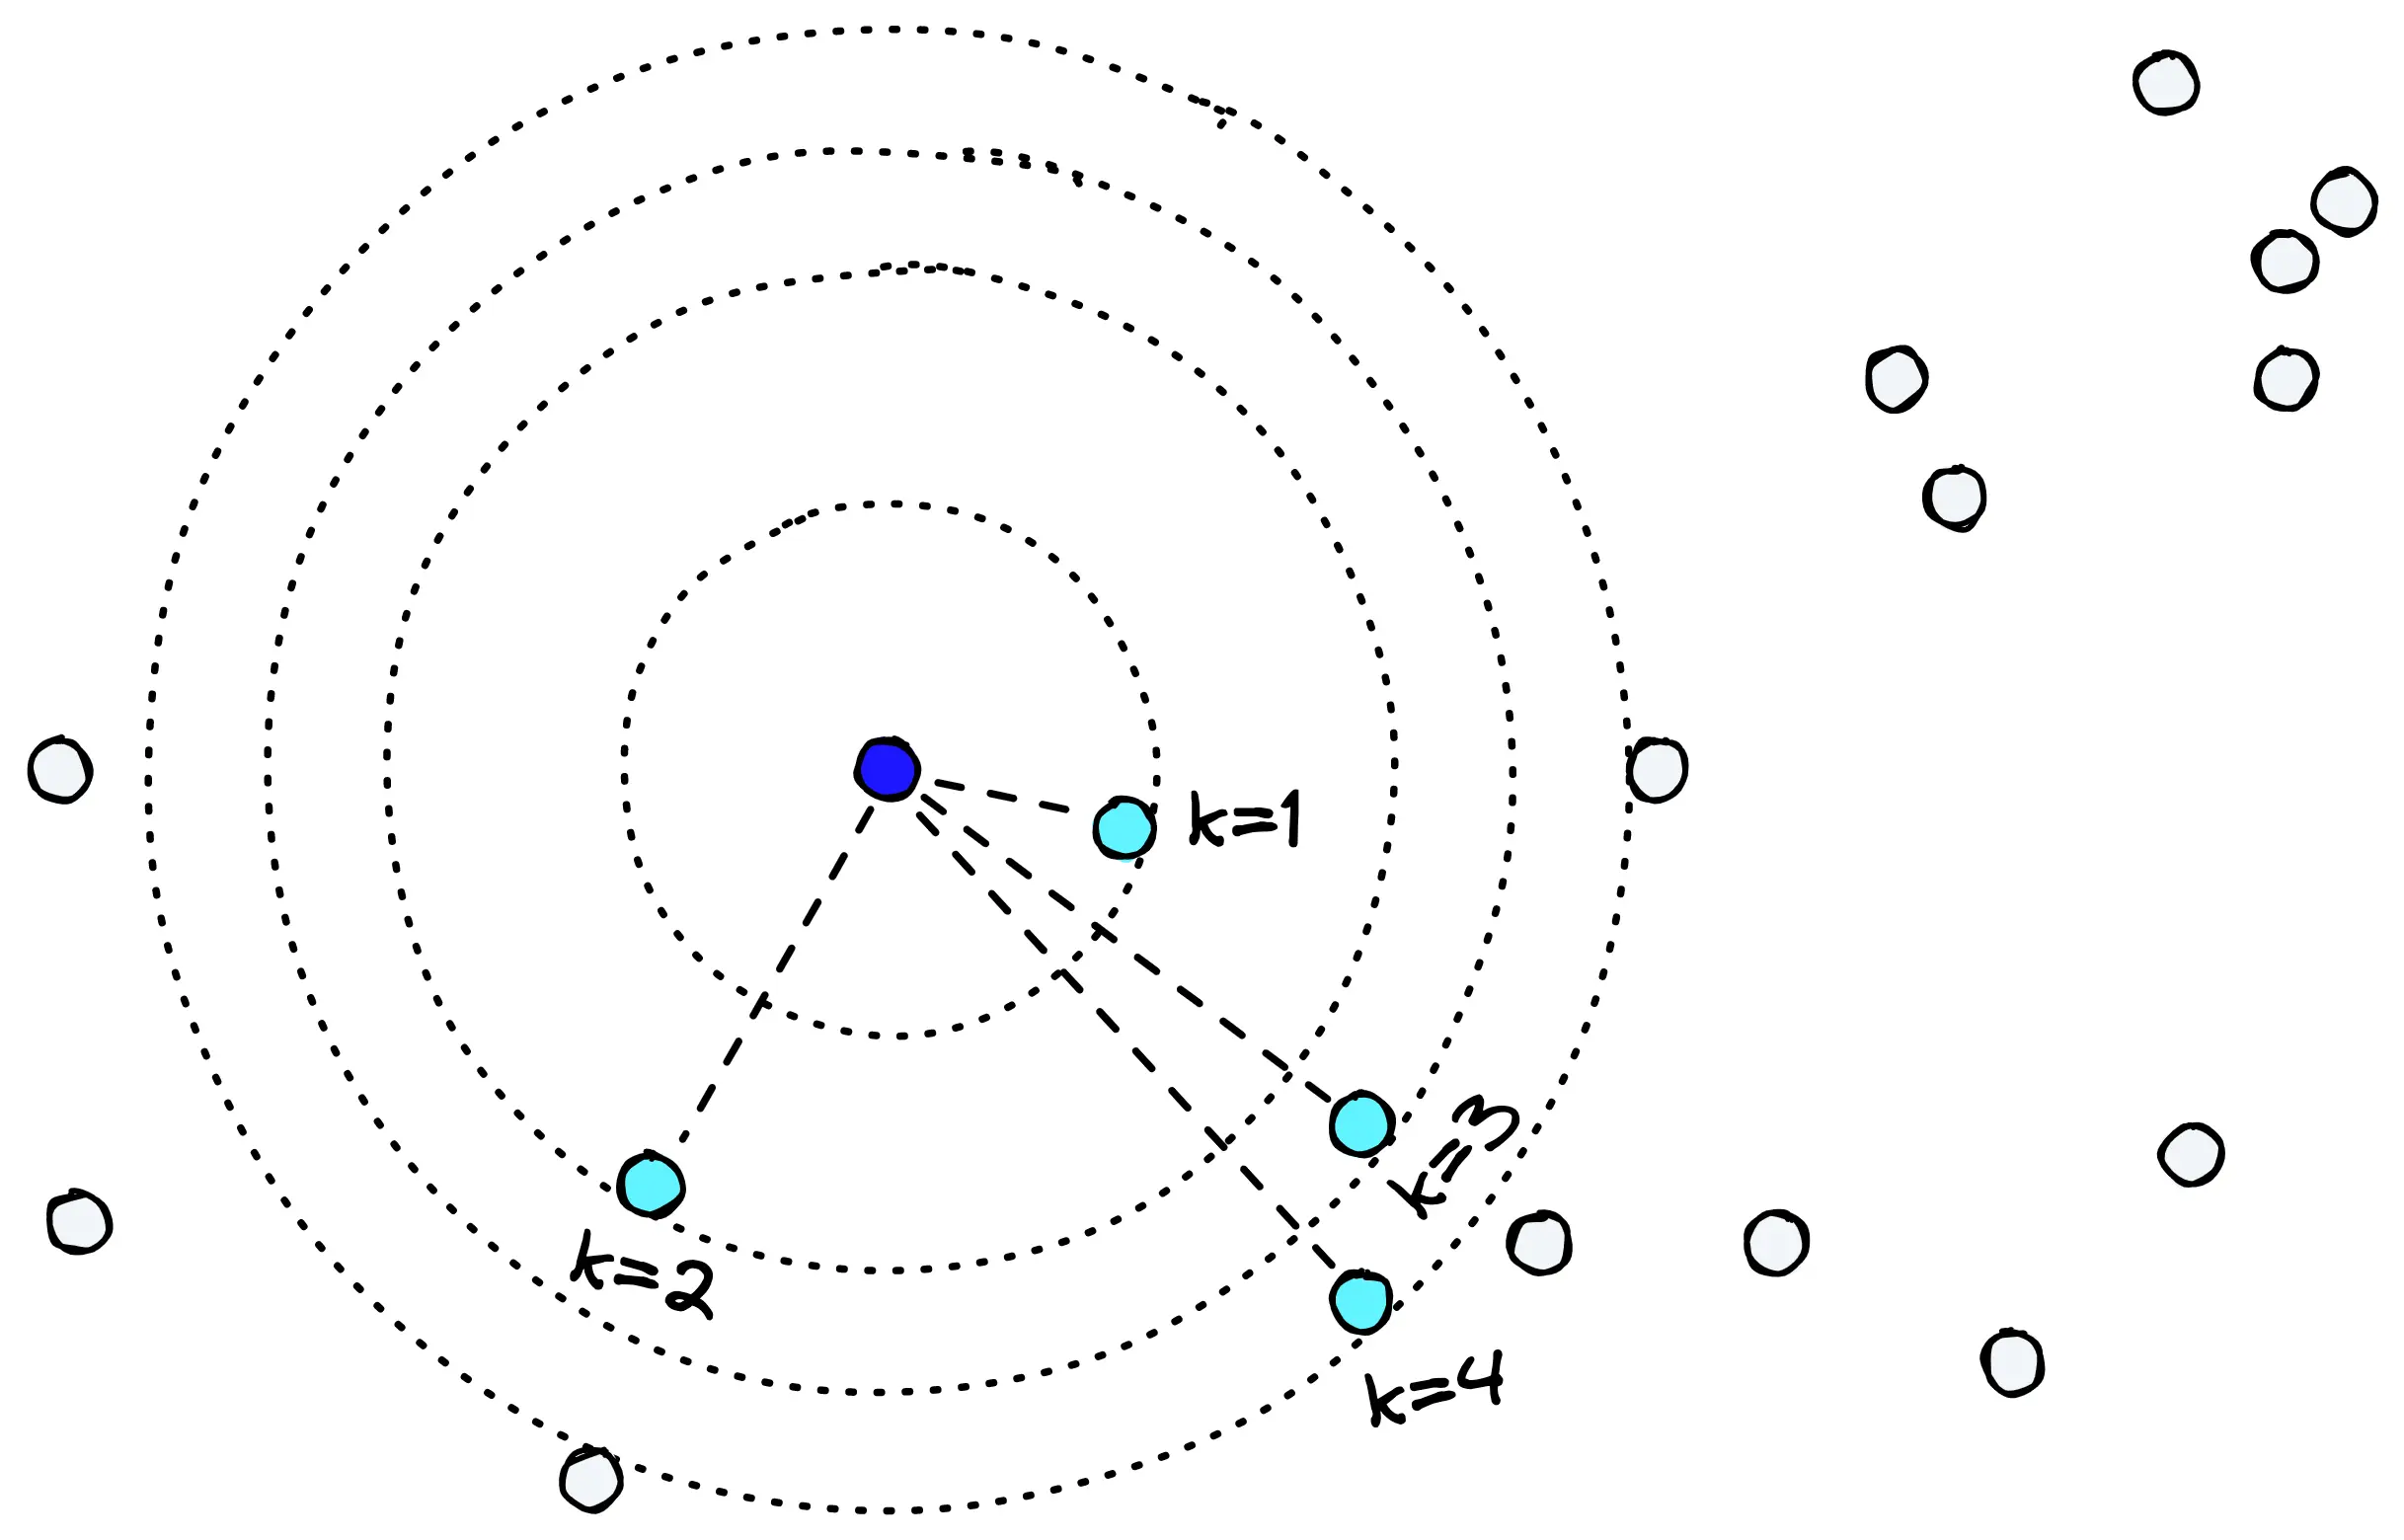

In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

def calculate_coherence_score(data, min_k=2, max_k=10):
    coherence_scores = []

    for k in range(min_k, max_k + 1):
        # Train BERTopic model with K topics
        model = BERTopic(nr_topics=k)
        topics, _ = model.fit_transform(data)

        # Extract topic words
        topic_words = [ [word for word, _ in model.get_topic(topic)] for topic in model.get_topics().keys() if topic != -1 ]

        # Prepare data for Coherence Model
        tokenized_data = [doc.split() for doc in data]
        dictionary = Dictionary(tokenized_data)

        # Compute Coherence Score
        coherence_model = CoherenceModel(topics=topic_words, dictionary=dictionary, texts=tokenized_data, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((k, coherence_score))

        print(f"K={k}, Coherence Score={coherence_score}")

    return coherence_scores

# Example usage with 'tweets' dataset
coherence_scores = calculate_coherence_score(tweets, min_k=2, max_k=20)


K=2, Coherence Score=0.42914201131888385
K=3, Coherence Score=0.4350309491153235
K=4, Coherence Score=0.42369105702360993
K=5, Coherence Score=0.43880723166590047
K=6, Coherence Score=0.4766497522558903
K=7, Coherence Score=0.45039648123055837
K=8, Coherence Score=0.472199469392749
K=9, Coherence Score=0.4297664964560186
K=10, Coherence Score=0.4103521666165299
K=11, Coherence Score=0.35987646862250877
K=12, Coherence Score=0.42134754824315174
K=13, Coherence Score=0.40827831471111814
K=14, Coherence Score=0.3870361170211194
K=15, Coherence Score=0.40423477650454254
K=16, Coherence Score=0.3977124580115504
K=17, Coherence Score=0.38851072531023684
K=18, Coherence Score=0.38959759485886303
K=19, Coherence Score=0.43259678163508897
K=20, Coherence Score=0.3995604091101179


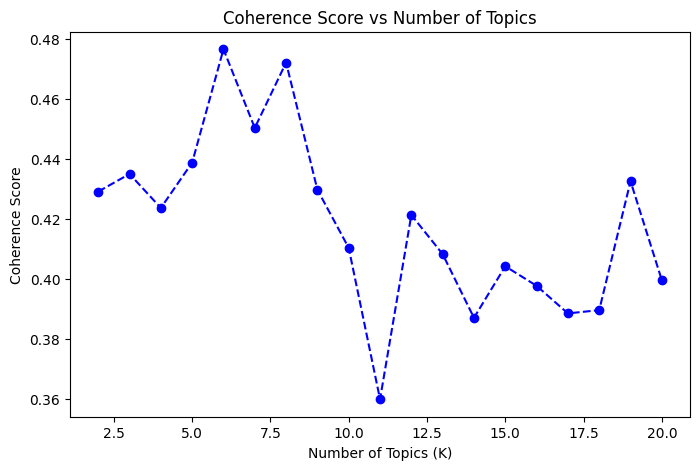

In [ ]:
import matplotlib.pyplot as plt

k_values, scores = zip(*coherence_scores)

plt.figure(figsize=(8,5))
plt.plot(k_values, scores, marker='o', linestyle='dashed', color='b')
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()


In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

def calculate_coherence_score(data, min_k=2, max_k=10):
    coherence_scores = []

    for k in range(min_k, max_k + 1):
        # Train BERTopic model with K topics
        model = BERTopic(nr_topics=k)
        topics, _ = model.fit_transform(data)

        # Extract topic words
        topic_words = [ [word for word, _ in model.get_topic(topic)] for topic in model.get_topics().keys() if topic != -1 ]

        # Prepare data for Coherence Model
        tokenized_data = [doc.split() for doc in data]
        dictionary = Dictionary(tokenized_data)

        # Compute Coherence Score
        coherence_model = CoherenceModel(topics=topic_words, dictionary=dictionary, texts=tokenized_data, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((k, coherence_score))

        print(f"K={k}, Coherence Score={coherence_score}")

    return coherence_scores

# Example usage with 'tweets' dataset
coherence_scores = calculate_coherence_score(tweets, min_k=2, max_k=20)


In [ ]:
#Create BERTopic model with the optimal K
optimal_k = 6
final_topic_model1 = BERTopic(nr_topics=optimal_k)
new_topics, new_ = final_topic_model1.fit_transform(tweets)

In [ ]:
new_topic_info = final_topic_model1.get_topic_info()
print(new_topic_info)

   Topic  Count                                 Name  \
0     -1    452            -1_gold_medal_men_olympic   
1      0    265  0_india_first_congratulations_medal   
2      1    134     1_amp_go_congratulations_morning   
3      2     96       2_olympics_olympic_tokyo_games   
4      3     43        3_basketball_women_team_duffy   
5      4     10       4_taekwondo_like_uniform_looks   

                                      Representation  \
0  [gold, medal, men, olympic, women, olympics, f...   
1  [india, first, congratulations, medal, proud, ...   
2  [amp, go, congratulations, morning, good, day,...   
3  [olympics, olympic, tokyo, games, heat, swim, ...   
4  [basketball, women, team, duffy, flora, us, pl...   
5  [taekwondo, like, uniform, looks, watching, at...   

                                 Representative_Docs  
0  [another gold medal well done tom pidcock love...  
1  [medal india congratulations silver, first gol...  
2  [congrats dadies amp minions, loving amp stand

In [ ]:
final_topic_model1.visualize_topics()

In [ ]:
# Create a DataFrame to associate topics with clean_text
topic_df = pd.DataFrame({'Topic': new_topics, 'Text': df['clean_text'], 'Location': df['user_location']})

,Topic,Text,Location
295003,-1,congrats achievements far olympics,"Brussels, Belgium"
63678,1,reality vs new york times,"Enshi, Hubei, China."
101824,-1,live score wd group greysia polii apriyani rah...,Indonesia
60985,-1,tennis tokyo olympics stefanos becomes first g...,New Delhi
47225,0,year old gold medalist ethnic kurd western ira...,"Erbil, Kurdistan"
...,...,...,...
1594,-1,moment second world medal rankings girls power,she/her/muslim
66804,1,joe,"Lagos, Nigeria"
71151,-1,day breeders proposal choosing sex foal foal b...,QLD
65252,-1,win lose already made pakistan proud talha talib,Indian Occupied Kashmir


from matplotlib import pyplot as plt
topic_df['Topic'].plot(kind='hist', bins=20, title='Topic')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
topic_df['Topic'].plot(kind='line', figsize=(8, 4), title='Topic')
plt.gca().spines[['top', 'right']].set_visible(False)

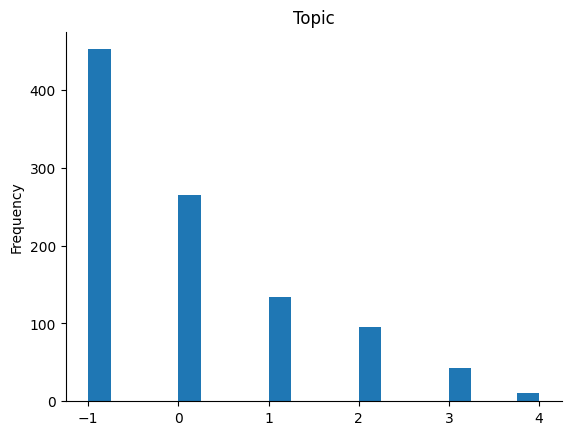

In [ ]:
# @title Topic

from matplotlib import pyplot as plt
topic_df['Topic'].plot(kind='hist', bins=20, title='Topic')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Filter out rows where Topic is 1
filtered_topic_df = topic_df[topic_df['Topic'] != -1]

In [ ]:
# Display the filtered DataFrame
print(filtered_topic_df)

        Topic                                               Text  \
63678       1                          reality vs new york times   
47225       0  year old gold medalist ethnic kurd western ira...   
28348       2                                bit happening tokyo   
96547       2   mark start latest take look stories olympians an   
22519       0    well done tkd bout today 've done country proud   
...       ...                                                ...   
143320      1             another heart break waiting great news   
67608       0          dear n't let get everything right draw wo   
156712      3                             drafting alyssa naeher   
66804       1                                                joe   
9836        1                     many congratulations 're proud   

                    Location  
63678   Enshi, Hubei, China.  
47225       Erbil, Kurdistan  
28348          Kulin nations  
96547             Maidenhead  
22519          Cork, Ireland

# **Dynamic Topic Modeling**

**Dynamic topic modeling (DTM)** is a collection of techniques aimed at analyzing the evolution of topics over time

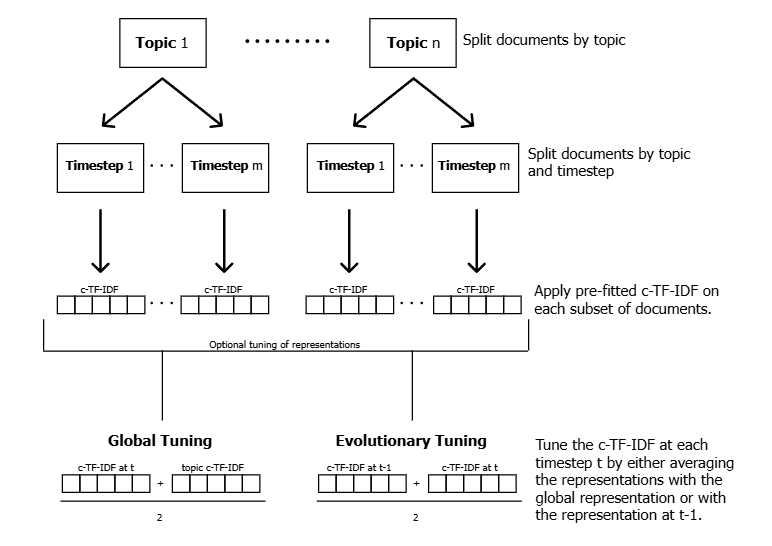

In [ ]:
topics_over_time = final_topic_model1.topics_over_time(tweets, timestamp, nr_bins=20)

In [ ]:
final_topic_model1.visualize_topics_over_time(topics_over_time, top_n_topics=10)

**Fine-tuning topics to generate labels, summaries, poems of topics using OpenAI**

In [ ]:
! pip install openai

In [ ]:
import openai
from bertopic.representation import OpenAI

In [ ]:
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')

client = openai.OpenAI(api_key=api_key)

In [ ]:
prompt = """
I have the following documents:
[DOCUMENTS]

These documents are about the following topic: "Tokyo Tweets".
Your job is to analyze the text, understand the context, and provide a brief summary of the common themes or insights across the documents.
"""
representation_model = OpenAI(client,prompt=prompt, model="gpt-4o-mini", delay_in_seconds=5)

In [ ]:
representation_model

OpenAI(client=<openai.OpenAI object at 0x7b0f909c9650>, delay_in_seconds=5,
       prompt='\n'
              'I have the following documents: \n'
              '[DOCUMENTS]\n'
              '\n'
              'These documents are about the following topic: "Tokyo '
              'Tweets". \n'
              'Your job is to analyze the text, understand the context, and '
              'provide a brief summary of the common themes or insights across '
              'the documents.\n',
       system_prompt='You are an assistant that extracts high-level topics '
                     'from texts.')

In [ ]:
LLM_topic_model = BERTopic(representation_model=representation_model)

In [ ]:
LLM_topic_model

In [ ]:
OPENAI_new_topics, OPENAI_ = LLM_topic_model.fit_transform(tweets)

In [ ]:
import pandas as pd

# Create a DataFrame for better visualization
LLM_topic_df = pd.DataFrame({'Tweet': tweets, 'Topic': OPENAI_new_topics})

# Count the number of tweets per topic
LLM_topic_counts = LLM_topic_df['Topic'].value_counts()

print(LLM_topic_counts)

Topic
-1     382
 0     156
 1      92
 2      69
 3      55
 4      43
 5      31
 6      25
 7      22
 8      19
 9      18
 10     14
 11     13
 12     13
 13     13
 14     12
 15     12
 16     11
Name: count, dtype: int64


In [ ]:
# Get the top words for each topic
for i in range(0,17):
    topic_words = LLM_topic_model.get_topic(i)
    print(f"Topic {i}: {', '.join([word for word, _ in topic_words])}")


Topic 0: The documents you provided primarily revolve around various sporting events, particularly focusing on different competitions and performances within the context of the Tokyo Olympics. Here are the common themes and insights across the documents:
Topic 1: The documents collectively celebrate a significant sporting achievement by an athlete named Chanu, who won India's first medal at the Tokyo Olympics. The common themes across the texts include expressions of congratulations and national pride in Chanu's accomplishment, emphasizing the joy and pride that comes with representing the country on an international stage. The documents also highlight the emotional impact of this achievement, marking it as a proud moment for the entire country. Overall, the texts reflect a unified celebration of success in sports, particularly focusing on the significance of Olympic victories for India.
Topic 2: The documents primarily focus on the themes of congratulations and a sense of progression,

In [ ]:
# Visualize the topics
LLM_topic_model.visualize_topics()